In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import time, datetime
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
gpu_idx = 3

if torch.cuda.is_available() and type(gpu_idx) == int:
    device = torch.device("cuda:{}".format(gpu_idx))
    current_device = torch.cuda.current_device()
    print("Device: {} ({})\n".format(torch.cuda.get_device_name(current_device), device))
else:
    device = torch.device('cpu')
    print("Device: CPU\n")

Device: GeForce RTX 2080 Ti (cuda:3)



# 1. Load Testing Data

In [3]:
import pickle, cv2

def gen_label(data, cls):
#     label = cls*np.ones([data.shape[0]])
    label = cls*np.ones([len(data)])
    return label

def Image_norm(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    """
    img: np.array (h, w, ch) or (n, h, w, ch) ~ [0, 255] integer
    mean and std vaules were used for normalizing input data to ImageNet models in torch 
    """
    return (img/255-mean)/std

def reshape4torch(img, norm = False):
    """
    (sample #, height, width, channel) -> (sample #, channel, height, width)
    """
    if norm == True:
        img = Image_norm(img)
        
    if len(img.shape) == 4:
        img = np.transpose(img, (0, 3, 1, 2))
        return img
    elif len(img.shape) == 3:
        img = np.transpose(img, (2, 0, 1))
        return np.expand_dims(img, axis=0)

def load_image_from_path(path_list, normalization = False, extract_name = False):
    data = []
    for i in path_list:
        temp = cv2.imread(i)

        data.append(temp)
    if extract_name != False:
        name = []
        for i in path_list:
            name.append(os.path.basename(i))
        return reshape4torch(np.asarray(data), norm = normalization), np.asarray(name)
    else:
        return reshape4torch(np.asarray(data), norm = normalization)

def test_data_load(filename):
    
    root = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'
    data_dir = root + '/database'
    
    with open(root + '/' + filename, "rb") as f:
        data_config = pickle.load(f)

    test_files = data_config['test_files']

    test_names, test_Xs, test_Ys = [], [], []
    for i, test_file in enumerate(test_files):
        test_path = [os.path.join(data_dir, f) for f in test_file]
        print(len(test_path))
        test_Ys.append(gen_label(test_path, int(i)))

        imgs, filenames = load_image_from_path(test_path, extract_name = True)
        test_Xs.append(imgs)
        test_names.append(filenames)
        
    test_name = np.concatenate(test_names)
    test_X = np.concatenate(test_Xs)
    test_Y = np.concatenate(test_Ys)
    
    return test_name, test_X, test_Y

In [4]:
test_name, test_X, test_Y = test_data_load('data_config_np-hd_frb_sv.pkl')

1005
1362


In [5]:
test_X.shape, test_Y.shape

((2367, 3, 512, 512), (2367,))

# 2. Load Model

In [6]:
class CNN_v1(nn.Module):
    def __init__(self, n_ch, n_cls):
        super().__init__()

        self.conv1_1 = nn.Conv2d(n_ch, 16, 3, 1, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp1 = nn.MaxPool2d(2, 2)
        
        self.conv2_1 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.conv2_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp2 = nn.MaxPool2d(2, 2)
        
        self.conv3_1 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.conv3_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp3 = nn.MaxPool2d(2, 2)
        
        self.conv4_1 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv4_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp4 = nn.MaxPool2d(2, 2)

        self.conv5_1 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.conv5_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp5 = nn.MaxPool2d(2, 2)
        
        self.conv6_1 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.conv6_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp6 = nn.MaxPool2d(2, 2)
        
        self.conv7_1 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.maxp7 = nn.MaxPool2d(2, 2)
        
        self.dense1 = nn.Linear(4*4*64, 100)
        self.dropout1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(50, n_cls)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxp1(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxp2(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.maxp3(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.maxp4(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = self.maxp5(x)
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = self.maxp6(x)
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = self.maxp7(x)
        # flatten
        x = x.view(-1, 4*4*64)
        feature = F.relu(self.dense1(x))
        x = self.dropout1(feature)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.dense3(x)
        x = F.softmax(x, dim = -1)
        return x

모델명 prefix로 모델 찾기

In [7]:
model_dir = './model/'
model_name = 'np-hd_---_--'

def find_models(model_dir, model_name):
    model_list = [i for i in sorted(os.listdir(model_dir)) if model_name in i]
#     model_list = sorted(glob.glob('nh/model/{}*'.format(model_name)))
    return model_list

model_list = find_models(model_dir, model_name)
model_list

['np-hd_---_--_0.0001_32_2101221757_042_t_accr_0.9350_t_loss_0.376242_v_accr_0.9366_v_loss_0.374310.pt']

In [8]:
n_ch = 3
n_cls = 2

network = CNN_v1(n_ch, n_cls)
        
model = network
model = model.to(device)

model_file = model_list[-1]

model.load_state_dict(torch.load(model_dir + model_file, map_location=lambda storage, loc: storage.cuda(gpu_idx)))
model.eval()

CNN_v1(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_1): Conv

# 3. Model Inference

In [9]:
def batch_idxs(dataset, batch_size = 32, shuffle = False):

    idxs = np.arange(len(dataset))
    total_size = len(idxs)
    if shuffle:
        np.random.shuffle(idxs)
    start = 0
    b_idxs = []
    while True:
        if total_size > start + batch_size: 
            b_idxs.append(list(idxs[start:start+batch_size]))  
            start += batch_size
        elif total_size <= start + batch_size: 
            b_idxs.append(list(idxs[start:]))
            break 
    return b_idxs

def progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '#' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r{} |{} | {}{} {}'.format(prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
def sec_to_m_s_ms(sec):
    """
    sec: time.time() - start_time
    output: ex) 00:47.421
    """
    min_sec = time.strftime("%M:%S", time.gmtime(sec))
    ms = '{:03d}'.format(int((sec - int(sec))*1000))   
    return '.'.join([min_sec, ms])
    
def prediction(x):
    prob = model(torch.tensor(x, device=device).float())
    _, pred = torch.max(prob, 1)

    return prob.cpu().detach().numpy(), pred.tolist()

In [10]:
batch_size = 20
x = test_X

start_time = time.time()
batches = batch_idxs(x, batch_size = batch_size)
score, pred = [], []
for i, batch in enumerate(batches):   
    s, p = prediction(x[batch, :, :, :])
    score.append(s), pred.append(p)
    progress_bar(i+1, len(batches), prefix = '{}: {}(*{})'.format(len(x), len(batches), batch_size), 
                  suffix = 'prediction', barLength = 50)
score, pred = np.concatenate(score), np.concatenate(pred)

pred_time = time.time() - start_time
pred_time = sec_to_m_s_ms(pred_time)

2367: 119(*20) |################################################## | 100.0% prediction


In [11]:
pred_time

'00:03.406'

In [12]:
score

array([[1.3637460e-03, 9.9863619e-01],
       [9.8573816e-01, 1.4261808e-02],
       [9.9999988e-01, 8.8035016e-08],
       ...,
       [2.5357142e-26, 1.0000000e+00],
       [6.1062559e-13, 1.0000000e+00],
       [9.7706392e-13, 1.0000000e+00]], dtype=float32)

In [13]:
pred

array([1, 0, 0, ..., 1, 1, 1])

# 4. Evaluation

## 4.1. Confusion Matrix

하나의 모델의 성능을 한번에 파악하기 좋으나, 여러 모델을 비교할 때는 부적합하다고 생각함

In [14]:
from sklearn.metrics import confusion_matrix
from itertools import product

true = test_Y
cm = confusion_matrix(true, pred)

In [15]:
class_name = ['Normal', 'Abnormal']
x_angle = 0

def plotCM(cm, value_size, mode):

    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    thresh = cm.max()/2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        if mode == 'percent':
            value = np.round(cm[i, j]/(np.sum(cm, 1)[i]), 3)
        elif mode == 'num':
            value = cm[i, j]
        plt.text(j, i, value,
                 fontsize = value_size,
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.ylabel('Actual', fontsize = 20)
    plt.xlabel('Predicted', fontsize = 20)
    plt.xticks([i for i in range(len(class_name))], class_name, rotation=x_angle, fontsize = 22)
    plt.yticks([i for i in range(len(class_name))], class_name, rotation=0, fontsize = 22)

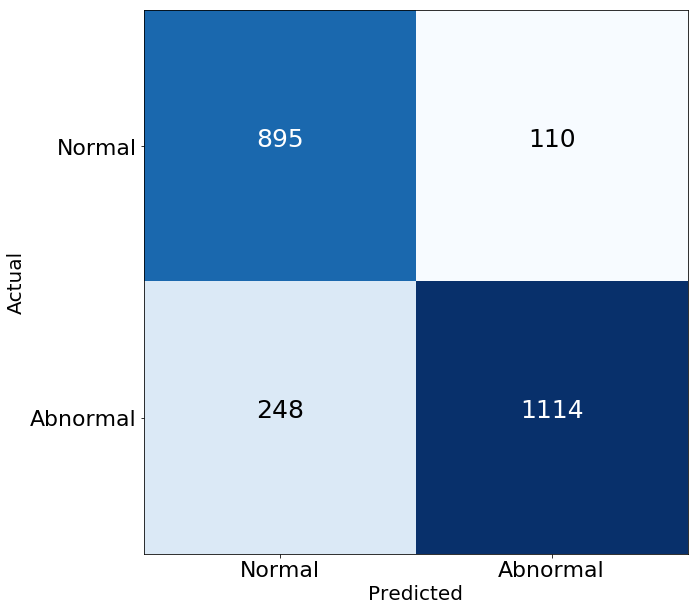

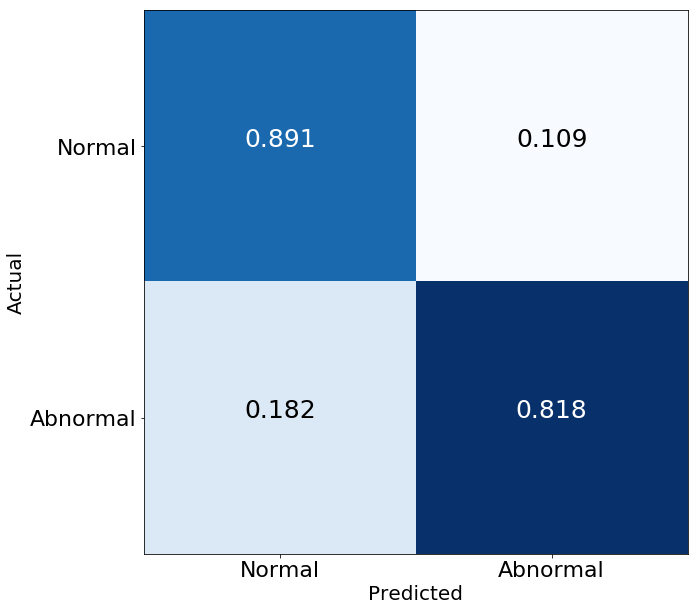

In [16]:
save_path = './outputs/'
save_name = model_name

if save_path != None:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
modes = ['num', 'percent']
for i, m in zip(range(len(modes)), modes):
    fig = plt.figure(figsize = (13, 10))
    plotCM(cm, value_size = 25, mode = m)   
    plt.show()
    if save_path != None:
        fig.savefig(save_path + '{}_CM_{}.png'.format(save_name, m), bbox_inches='tight')
    plt.close(fig)

위의 Confusion Matrix를 갯수로 읽을때, 

왼쪽상단부터 시계방향으로 True Negative, False Negative, True Positive, False Positive이다.

- True Positive (TP): Positive로 예측했는데, 맞은 경우 (실제 Positive)
- False Positive (FP): Positive로 예측했는데, 틀린 경우 (실제 Negative)



위의 Confusion Matrix를 Percent로 읽을때, 

왼쪽상단부터 시계방향으로 Specificity, 1-Specificity(false positive rate), Sensitivity, 1-Sensitivity(false negative rate) 이다.

- Sensitivity: 실제 Positive 샘플 중에 맞춘 갯수의 비율
- Specificity: 실제 Negative 샘플 중에 맞춘 갯수의 비율

- Sensitivity = TP / TP + FN
- Specificity = TN / TN + FP

TP, FN, TN, FP들을 각각 보고 모델이 어떤 부분을 놓치고 있는 지 Error Analysis를 해야한다.

In [17]:
def confusion_idx(true, pred):
    fn_idx = np.where(true - pred == 1)[0]
    tp_idx = np.setxor1d(np.where(true == 1), fn_idx)
    fp_idx = np.where(true - pred == -1)[0]
    tn_idx = np.setxor1d(np.where(true == 0), fp_idx)
    return tp_idx, fn_idx, tn_idx, fp_idx

In [18]:
confusion_idx(true, pred)

(array([1007, 1008, 1009, ..., 2364, 2365, 2366]),
 array([1005, 1006, 1012, 1013, 1014, 1015, 1016, 1022, 1023, 1024, 1029,
        1030, 1031, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1043,
        1044, 1053, 1063, 1066, 1067, 1069, 1077, 1079, 1080, 1082, 1083,
        1084, 1085, 1089, 1090, 1091, 1092, 1094, 1123, 1141, 1142, 1143,
        1150, 1151, 1175, 1176, 1197, 1209, 1210, 1211, 1212, 1215, 1216,
        1217, 1218, 1221, 1233, 1251, 1258, 1265, 1271, 1272, 1275, 1292,
        1293, 1296, 1309, 1312, 1320, 1333, 1334, 1335, 1336, 1338, 1341,
        1342, 1346, 1347, 1351, 1356, 1357, 1359, 1361, 1364, 1365, 1367,
        1368, 1369, 1373, 1376, 1378, 1383, 1384, 1387, 1410, 1422, 1430,
        1458, 1459, 1461, 1465, 1466, 1477, 1478, 1480, 1495, 1534, 1548,
        1549, 1553, 1554, 1555, 1570, 1571, 1576, 1588, 1589, 1595, 1596,
        1672, 1680, 1681, 1684, 1763, 1764, 1765, 1768, 1769, 1771, 1773,
        1774, 1775, 1789, 1790, 1791, 1792, 1793, 1795, 1797,

## 4.2. Accuracy, Sensitivity, Specificity, NPV, PPV

의료 분야에서 분류 문제에서 Confusion Matrix와 더불어 사용되는 metric들이고, <br>
참고로, Sensitivity는 Recall이고, PPV는 Precision임

In [19]:
def cm2metric(cm):

#         assert 0 not in np.sum(cm, axis = 0),'Totally misclassified class exists'

    if 0 in np.sum(cm, axis = 0):
        print('Totally misclassified class exists')

    if len(cm) == 2:

        acc = round(100*np.trace(cm) / np.sum(cm), 2)
        sen = round(100*cm[1, 1] / np.sum(cm[1, :]), 2)
        spe = round(100*cm[0, 0] / np.sum(cm[0, :]), 2)

        if not (np.sum(cm[:, 0]) == 0 and np.sum(cm[:, 1]) == 0):
            npv = round(100*cm[0, 0] / np.sum(cm[:, 0]), 2)
            ppv = round(100*cm[1, 1] / np.sum(cm[:, 1]), 2)

        elif np.sum(cm[:, 0]) == 0:
            npv = 0
            ppv = round(100*cm[1, 1] / np.sum(cm[:, 1]), 2)
        elif np.sum(cm[:, 1]) == 0:
            npv = round(100*cm[0, 0] / np.sum(cm[:, 0]), 2)
            ppv = 0

        return [acc, sen, spe, npv, ppv]

In [20]:
cm2metric(cm)

[84.88, 81.79, 89.05, 78.3, 91.01]

In [21]:
model_name

'np-hd_---_--'

사실 여러 모델들을 비교할 수 있어야하니, DataFrame형태로 정리해주면 csv로 저장하면 편하다

In [22]:
df = pd.DataFrame(columns = ['ACC', 'SEN', 'SPE', 'NPV', 'PPV'])
df.loc[model_name] = cm2metric(cm)
   
df

,ACC,SEN,SPE,NPV,PPV
np-hd_---_--,84.88,81.79,89.05,78.3,91.01


In [23]:
df.to_csv(save_path + '{}_performance.csv'.format(model_name), encoding='utf-8-sig', index = True)  

## 4.3. Accuracy by type

binary classifier이어도 type별로 accuracy가 어떻게 되는지 평가하는 것은 유의미함

In [24]:
def compute_accr(y, pred, print_show = True):
    num_correct = np.sum(y == pred)
    accr = round(100 * num_correct / len(y), 2)
    if print_show == True:
        print("Accuracy: {:.2f} % ({} / {})\n".format(accr, num_correct, len(y)))
    return accr

def inference(x, batch_size):
    batches = batch_idxs(x, batch_size = batch_size)
    score, pred = [], []
    for i, batch in enumerate(batches):   
        s, p = prediction(x[batch, :, :, :])
        score.append(s), pred.append(p)
        progress_bar(i+1, len(batches), prefix = '{}: {}(*{})'.format(len(x), len(batches), batch_size), 
                      suffix = 'prediction', barLength = 50)
    score, pred = np.concatenate(score), np.concatenate(pred)   
    return score, pred
    
def get_accuracy(x, y, batch_size = 20):
    _, pred = inference(x, batch_size)
    accr = compute_accr(y, pred, print_show = True)
    return accr

def get_accuracy_by_type(filename, X, Y):
   
    label_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'
    label = pd.read_csv(label_dir + '/label.csv', index_col = 0)
    
    types = []
    accrs = []
    for sub_cls in label.columns[:-1]:
    
        x, y = [], []
        for name, img, cls in zip(filename, X, Y):
            if label.loc[('').join(name.split('__c_-_-_-'))][sub_cls] == 1:
                x.append(img)
                y.append(cls)
        
        if len(x) != 0:
            types.append(sub_cls)
            x = np.concatenate([x])
            y = np.asarray(y)

            accrs.append(get_accuracy(x, y)) 
    return types, accrs

In [25]:
types, accrs = get_accuracy_by_type(test_name, test_X, test_Y)

1005: 51(*20) |################################################## | 100.0% prediction
Accuracy: 89.05 % (895 / 1005)

1362: 69(*20) |################################################## | 100.0% prediction
Accuracy: 81.79 % (1114 / 1362)

663: 34(*20) |################################################## | 100.0% prediction
Accuracy: 85.07 % (564 / 663)

370: 19(*20) |################################################## | 100.0% prediction
Accuracy: 75.95 % (281 / 370)

2: 1(*20) |################################################## | 100.0% prediction
Accuracy: 100.00 % (2 / 2)

293: 15(*20) |################################################## | 100.0% prediction
Accuracy: 96.59 % (283 / 293)

733: 37(*20) |################################################## | 100.0% prediction
Accuracy: 79.54 % (583 / 733)

297: 15(*20) |################################################## | 100.0% prediction
Accuracy: 80.47 % (239 / 297)

410: 21(*20) |################################################## | 100.0%

In [26]:
df = pd.DataFrame(columns = types)
df.loc[model_name] = accrs
   
df

,negative,positive,hemorrhagic,red_spot,angioectasia,active_bleeding,depressed,erosion,ulcer,stricture,protruded,small_bowel_tumor
np-hd_---_--,89.05,81.79,85.07,75.95,100.0,96.59,79.54,80.47,78.54,70.83,0.0,0.0


In [27]:
df.to_csv(save_path + '{}_performance_by_type.csv'.format(model_name), encoding='utf-8-sig', index = True)  

## 4.4. ROC curve and AUC

binary classifier들의 성능을 평가하는 metric으로 모델의 예측값을 통해 threshold에 따른 true positive rate(sensitivity)와 false positive rate(1-specificity)를 그린 커브이다. 곡선 아래있는 영역인 AUC (Area under curve) 값을 사용하며 optimal threshold를 찾기도한다.

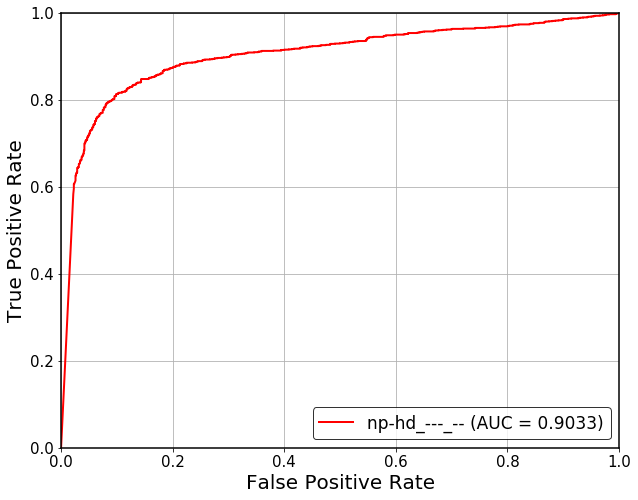

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_Y, score[:, 1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, 1, figsize= (10, 8))
ax.plot(fpr, tpr, lw = 2, color = 'r', label='{} (AUC = {:.4f})'.format(model_name, roc_auc))

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(labelsize = 15)
ax.set_xlabel('False Positive Rate', fontsize = 20)
ax.set_ylabel('True Positive Rate', fontsize = 20)

ax.set_xlim([0, 1.0])
ax.set_ylim([0.0, 1])

ax.legend(fontsize = 17, borderpad = 0.4, edgecolor = 'k', loc="lower right")

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.grid()

plt.show()

사실, 의학 분야에서는 단순히 양성예측확률이 50%이 넘는다고 양성이라고 예측하는 것보단 통계적 분석과 더불어 여러 방법으로 optimal한 성능을 가진 threshold(cut-off)를 찾아 그 값에 따른 성능을 평가하는 것으로 보인다. 

여기선 gmean score를 계산해 optimal threshold를 찾는다.

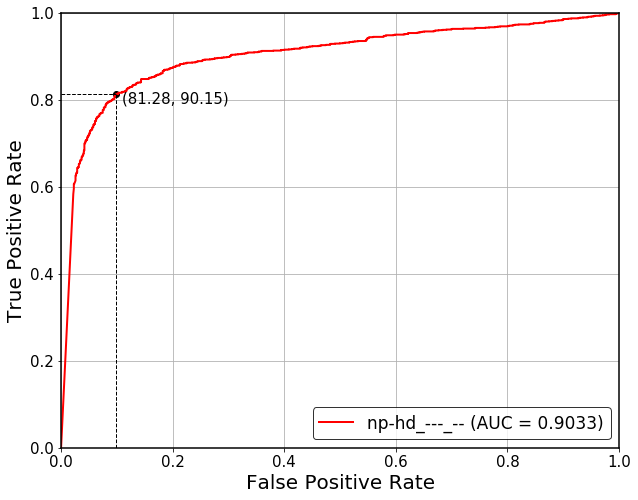

In [29]:
fpr, tpr, thresholds = roc_curve(test_Y, score[:, 1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, 1, figsize= (10, 8))
ax.plot(fpr, tpr, lw = 2, color = 'r', label='{} (AUC = {:.4f})'.format(model_name, roc_auc))

ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(labelsize = 15)
ax.set_xlabel('False Positive Rate', fontsize = 20)
ax.set_ylabel('True Positive Rate', fontsize = 20)

ax.set_xlim([0, 1.0])
ax.set_ylim([0.0, 1])

gmean_score = np.sqrt(tpr * (1-fpr))
idx = np.argmax(gmean_score)

ax_xlim, ax_ylim = ax.get_xlim(), ax.get_ylim()

width = ax_xlim[1] - ax_xlim[0]
height = ax_ylim[1] - ax_ylim[0]

ax.scatter(fpr[idx], tpr[idx], color = 'k')
ax.axhline(tpr[idx], color = 'k', linestyle='dashed', linewidth=1, xmax=(fpr[idx]- ax_xlim[0])/width)
ax.axvline(fpr[idx], color = 'k', linestyle='dashed', linewidth=1, ymax=(tpr[idx]- ax_ylim[0])/height)
ax.text(fpr[idx] + 0.01, tpr[idx] - 0.02, '({:.2f}, {:.2f})'.format(100*tpr[idx], 100*(1-fpr[idx])), fontsize = 15)

ax.legend(fontsize = 17, borderpad = 0.4, edgecolor = 'k', loc="lower right")

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.grid()

plt.show()

fig.savefig(save_path + '{}_ROC_curve.png'.format(model_name), bbox_inches='tight')

아래 threshold로 positive/negative를 예측하면 위와 같은 최적의 (optimal) 성능으로 평가할 수 있다는 말이다.

In [30]:
thresholds[idx]

0.6573638